# Data Fitting and Time Series Practical.

by Dominic Waithe (2019)  

Exercise:   
To demonstrate and utilise different tools for data processing and fitting. We show regression, time series analysis and Gaussian fitting.


Instructions:  
Work through the notebook cell-by-cell. Where you see TODO, this means you need to do something. Optional TODO means you should do it if you are finding things too easy and have enough time.
Many of the exercises below utilise the Skimage Python library, if in doubt, google the function names, to find out additional description.
Some of the cells also involve plotting. If you are having trouble understanding the plotting with Matplotlib, then I recommend the following text: https://jakevdp.github.io/PythonDataScienceHandbook/04.00-introduction-to-matplotlib.html


In [19]:
#Library imports for this notebook. Please remember to run before any other cells.
%matplotlib inline
from scipy import ndimage as ndi
import matplotlib.pyplot as plt
from skimage import data, img_as_float,color, img_as_ubyte
from skimage import color, io
from sklearn.linear_model import LinearRegression
from matplotlib import cm
import numpy as np
import pickle
import tifffile
from lmfit import minimize, Parameters,report_fit,report_errors, fit_report
#pip install git+https://github.com/dwaithe/nanosimpy
from nanosimpy import equations_to_fit as eq


### Linear Regression example
Here we show an example of linear regression.

In [ ]:

data = np.array([[18,  510],[20,  590],[22,  560],[23,  510],[23,  460],[25,  490],[27,  560],[28,  510],
[29,  460],[32,  410],[37,  420],[41,  460],[46,  450],[49,  380],[53,  460],[55,  420],[63,  350],
[65,  420],[66,  300],[67,  410],[68,  300],[70,  390],[71,  320],[72,  370],[73,  280],[74,  420],
[75,  460],[77,  360],[79,  310],[82,  360]])


n = data.shape[0]
x = data[:,0]
y = data[:,1]

#Using the analytical solution for linear regression which is in the notes:
b0 = (np.average(y)*(np.sum(x**2))-np.average(x)*np.sum(x*y))/(np.sum(x**2)-n*np.average(x)**2)
print('b0',b0) 
# equation (2).
b1 = ((np.sum(x*y))-n*np.average(x)*np.average(y))/(np.sum(x**2)-n*np.average(x)**2)
print('b1',b1)
#visualisation
xx = np.linspace(np.min(x),np.max(x),2)
yy = np.array(b0+ b1 * xx)

#plotting.
plt.plot(xx,yy,'-',color='pink')
plt.scatter(data[:,0], data[:,1],color='k')
plt.title("XY plot comparing the independent variable and the dependent variable ")
plt.xlabel("Independent variable (x)")
plt.ylabel("Dependent variable (y)");


#TODO:
#Using the function available through the below link, implement linear regression on the data above.
#https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html
#You will have to format you X input a little differently. use x = data[:,np.axis,0]. This is because it is capable of multi-dimensional regression.
#You should get the same b0 and b1 values as above.


#Visit online the interactive demonstration:
#http://userweb.molbiol.ox.ac.uk/dwaithe/WIMM_Advanced_Imaging/linearRegressiond4.html
#Can you get the same parameters as the fit. Do you agree with the choice? 


### Correlation of time series data
Remember this from the lecture? This is a visualisation illustrating what happens during a Fluorescence Correlation Spectroscopy experiment.  
![FCS intensity](src/pointFCS_ani.gif "segment")  
Fluorescently tagged proteins/molecules pass through a microscope illumination spot and become fluorescent.
The fluorescence is measured over time to generate an intensity time series.

To extract meaning from this data, we want to analyse the fluctuations and measure how long they are. This will allow us to determine how fast the
molecules within the sample are diffusing. To do this we correlate the intensity time trace we measure from the above example.
This is a graphical representation for correlation:  
![FCS intensity](src/FCS_intensity_correlation.gif "segment")   
If you want this animation to stop, just double-click this cell.
The dark blue trace represents our time series. The light-blue trace is the same trace but is moved along the sequence and compared at every point.
Below is the function which performs this correlation on our input data.

In [3]:
def correlate_linear(a, b):
    """Return linear correlation of two vectors using DFT."""
    size = a.size
        
    a_mean = a.mean()
    b_mean = b.mean()
    
    # subtract mean and pad with zeros to twice the size
    a = np.pad(a-a_mean, a.size//2, mode='constant')
    b = np.pad(b-b_mean, b.size//2, mode='constant')
    
    # forward DFT
    a = np.fft.rfft(a)
    b = np.fft.rfft(b)
    # multiply by complex conjugate
    c = a * b.conj()
    # reverse DFT
    c = np.fft.irfft(c)
    # positive delays only
    c = c[:size // 2]
        
    # normalize with the averages of a and b
    c /= size * a_mean * b_mean
    
    return c

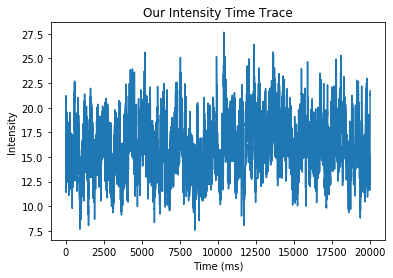

In [6]:
#Now we need to import some data.
file_dict = pickle.load(open('images/parameters.pickle', 'rb'))
time_step = 1. #ms. This is the time-step. We need this to calibrate our plotting.
data = file_dict['trace'][0]
_time = np.arange(data.shape[0])*time_step
#We then plot it:
plt.plot(_time,data);
plt.title("Our Intensity Time Trace")
plt.ylabel("Intensity")
plt.xlabel("Time (ms)");

In [ ]:
#Now we autocorrelate our time series by running it through our correlate function.
#We now want to do auto-correlation. To do this call correlate_linear() on our data. You will need to pass the variable data for both inputs.
corr_data = #insert correlate_linear here.
_time_corr = np.arange(corr_data.shape[0])*time_step
#We plot FCS on a logarithmic access to get the characteristic curve.
plt.semilogx(_time_corr,corr_data)
plt.xlabel('Tau (ms)')
plt.ylabel('Autocorrelation');

In [ ]:
#We set our initialisation parameters of our fit. 
param = Parameters()
param.add('offset', value=0.01, min=-0.5, max=1.5, vary=True); #Controls the offset of the fit from the baseline (e.g. 0)
#TODO: 
#Above we have added one parameter to our fit initialisation. We need to add some more.
#Please add the following in a similar way to the parameter 'offset' is added above:
#'GN0' value=3000 min=-0.0001 max=3000.0 vary=True    #Controls the amplitude (i.e. height) of the curve.
#'A1' value=1.000 min=0.0001 max=1.0000 vary=False #If we had more than one diffusing species we could change this.
#'txy1' value=0.10 min=0.001 max=2000.0 vary=True  #This is the apparent transit time of the diffusing species through the spot.
#'alpha1' value=1 min=0.2 max=2.0 vary=True        #This is our anomalous factor which allows non-ideal diffusion. 
#If the code runs, then the model parameters are working correctly. The model won't fit well, without changeing some of the parameter values (see TODO below).

#The equation for our model can be seen here: https://github.com/dwaithe/nanosimpy/blob/master/nanosimpy/equations_to_fit.py
options = {'Dimen':1,'Diff_eq':1,'Triplet_eq':1,'Diff_species':1} #Here we select our specific model. Don't worry about this at this stage.
#This is our minimize function, which optimises our model parameters:
#eq.residual evaluates the loss between our model and our data.
res = minimize(eq.residual, param, args=(_time_corr,corr_data, options))

#These are the output residuals.
residualVar = res.residual

output = fit_report(res.params)
print ('residual',res.chisqr)
plt.semilogx(_time_corr,corr_data,'go')
plt.semilogx(_time_corr,eq.equation_(res.params,_time_corr,options),'r')

#TODO:
#Once you run it you will see that the initial values of the parameters are not great, and the model (red) does not fit the data (green).
#Change the parameter values to see if you can get a good model fit.




In [ ]:
#This will print our output variables for our model.
res.params

In [ ]:
#You can access the learnt parameters by specifying the parameter name: res.params['parameter_name'].value
#TODO: Set txy1 below to calculate the rate of diffusion.

#Finally we calculate diffusion from our transit time measurement.
print('D ',((1.0/np.sqrt(2.0*np.log(2.0)))*float(file_dict['FWHMs'][0])/1000.0)**2/(4*txy1)*1000.0)
#You should get around 0.62 um2/s
    

### Gaussian Fitting
Gaussian fitting is one of the most common procedures to perform in N-Dimensional signal analysis (i.e. 1-D sequences, 2-D images and 3-D volumes).Furthermore general education relating to Gaussian functions, their properties and their varying anisotropies will be added.

In [36]:
#Here is a handy function which returns a 2-D Gaussian.
def Gaussian_2D(xx,yy,x_mu, y_mu, sig_x, sig_y, A):
    f = A*np.exp(-(((xx-x_mu)**2/(2*sig_x**2))+((yy-y_mu)**2/(2*sig_y**2))))
    return f

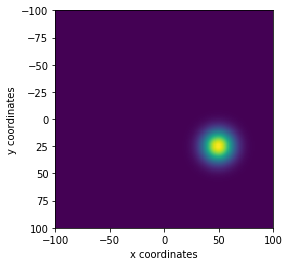

In [53]:
#In this cell, we generate and visualise our own Gaussian distribution: 

#Parameters of 2-D Gaussian distribution.
x_mu = 50 #Mean of Gaussian in x.
y_mu = 25 #Mean of Gaussian in y.
sig_x = 10 #Sigma of Gaussian in x (i.e. width).
sig_y = 10 #Sigma of Gaussian in y (i.e height).
A = 5 #Amplitude of Gaussian (i.e what the peak intensity value is).

#Generate grid.
xrange = np.arange(-100,101,1)
yrange =  np.arange(-100,101,1)
xx,yy = np.meshgrid(xrange,yrange)

#Evaluate function over grid.
f = Gaussian_2D(xx,yy,x_mu, y_mu, sig_x, sig_y, A)

plt.imshow(f,extent=[-100,100,100,-100])
plt.xlabel('x coordinates');
plt.ylabel('y coordinates');
#TODO:
#Play with the parameters. Try to get the Gaussian in the top-left corner.

Should closely resemble our inputs.
x_mu estimation: 4.999999999999999 y_mu estimation: 24.99999999999837
Amplitude (A) estimation: 5.0
sig_x estimation: 10.02496882788171
sig_y estimation: 10.024968827875526


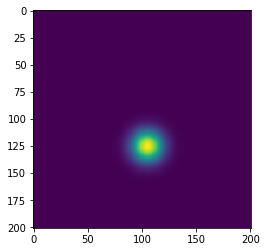

In [55]:
#Estimate parameters:
#Parameters of 2-D Gaussian distribution.
x_mu = 5 #Mean of Gaussian in x.
y_mu = 25 #Mean of Gaussian in y.
sig_x = 10 #Sigma of Gaussian in x (i.e. width).
sig_y = 10 #Sigma of Gaussian in y (i.e height).
A = 5 #Amplitude of Gaussian (i.e what the peak intensity value is).

f = Gaussian_2D(xx,yy,x_mu, y_mu, sig_x, sig_y, A)

#Below are the estimations for our initial parameters. These equations look worse than they really are.
#They represent the weighted mean and weighted sample standard deviation.
#https://en.wikipedia.org/wiki/Weighted_arithmetic_mean
#Essentially they provide us rough parameters of our Gaussian.
x_plot = np.sum(f,0) #we integrate with y with respect to x.
y_plot = np.sum(f,1) #we integrate with x with respect to y.
x_mu_est = np.sum(xrange*x_plot)/np.sum(x_plot) #Our Gaussian mean in the x-dimension.
y_mu_est = np.sum(yrange*y_plot)/np.sum(y_plot) #Our Gaussian mean in the y-dimension.
sig_x_est =np.sqrt(np.sum(x_plot*(xrange-x_mu_est)**2)/((xrange.shape[0]-1)*(np.sum(x_plot)/(xrange.shape[0])))) 
sig_y_est =np.sqrt(np.sum(y_plot*(yrange-y_mu_est)**2)/((yrange.shape[0]-1)*(np.sum(y_plot)/(yrange.shape[0]))))
A_est = np.max(f)#An easy one.

print('Should closely resemble our inputs.')
print('x_mu estimation:',x_mu_est,'y_mu estimation:',y_mu_est)
print('Amplitude (A) estimation:',A_est)
print('sig_x estimation:',sig_x_est)
print('sig_y estimation:',sig_y_est)

#Analytical methods like the above work, but are susceptible to noise or outliers.
#They do however provide a good estimate from which to do a finer grain fitting.
plt.imshow(f)

In [39]:
#This is where we try and fit our 2-D Gaussian.
#First we initialise our parameters:
param = Parameters()
param.add('x_mu', value=x_mu_est, min=np.min(xx), max=np.max(xx), vary=True); 
param.add('y_mu', value=y_mu_est, min=np.min(yy), max=np.max(yy), vary=True); 
param.add('sig_x', value=sig_x_est, min=0, max=xrange.shape[0], vary=True); 
param.add('sig_y', value=sig_y_est, min=0, max=yrange.shape[0], vary=True); 
param.add('A', value=A_est, min=0, max=yrange.shape[0], vary=True);

#Next we define our residuals equation:
def gauss_residuals(param,xx,yy,f):
    #We pass our param object which gets dynamically changed by the optimisation equation.
    #We also have xx and yy and f. These don't change and so are not in the param object.
    f0 = Gaussian_2D(xx,yy,param['x_mu'].value, param['y_mu'].value, param['sig_x'].value, param['sig_y'].value, param['A'].value)
    #We return our residuals, as a array of values.
    return f0-f
#This is where the magic happens, the minimisation:
res = minimize(gauss_residuals, param, args=(xx.reshape(-1),yy.reshape(-1),f.reshape(-1)))

In [ ]:
#Here is a nice summary of how our fit went. Now our parameter predictions(shown below) are very close to our value.
res

### Gaussian fitting with noise
We have seen above that numerical parameter estimation is fine and that fitting is a tiny bit better.
Now we add some Poisson noise and see how well our estimation and fitting goes.

--------numerical estimates--------
Should closely resemble our inputs but due to noise will not.
x_mu estimation: 4.155383971669513 y_mu estimation: 18.785089904520557
Amplitude (A) estimation: 6.406972353099442
sig_x estimation: 33.727078213216004
sig_y estimation: 35.449380266210284

--------fitting outputs--------
Should closely resemble our inputs. Fitting is more robust.
x_mu fit value: 5.011603495609137 y_mu fit value: 25.081332700798313
Amplitude (A) fit value: 4.965550262797015
sig_x fit value: 20.97741320578055
sig_y fit value: 20.939235063686528


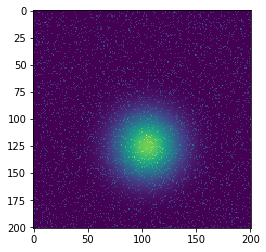

In [26]:
#Estimate parameters:
#Parameters of 2-D Gaussian distribution.
x_mu = 5 #Mean of Gaussian in x.
y_mu = 25 #Mean of Gaussian in y.
sig_x = 20 #Sigma of Gaussian in x (i.e. width).
sig_y = 20 #Sigma of Gaussian in y (i.e height).
A = 5 #Amplitude of Gaussian (i.e what the peak intensity value is).

f = Gaussian_2D(xx,yy,x_mu, y_mu, sig_x, sig_y, A)
f +=np.random.poisson(0.1,size=f.shape)

x_plot = np.sum(f,0) #we integrate with y with respect to x.
y_plot = np.sum(f,1) #we integrate with x with respect to y.
x_mu_est = np.sum(xrange*x_plot)/np.sum(x_plot) #Our Gaussian mean in the x-dimension.
y_mu_est = np.sum(yrange*y_plot)/np.sum(y_plot) #Our Gaussian mean in the y-dimension.
sig_x_est =np.sqrt(np.sum(x_plot*(xrange-x_mu_est)**2)/((xrange.shape[0]-1)*(np.sum(x_plot)/(xrange.shape[0])))) 
sig_y_est =np.sqrt(np.sum(y_plot*(yrange-y_mu_est)**2)/((yrange.shape[0]-1)*(np.sum(y_plot)/(yrange.shape[0]))))
A_est = np.max(f)#An easy one.
print('--------numerical estimates--------')
print('Should closely resemble our inputs but due to noise will not.')
print('x_mu estimation:',x_mu_est,'y_mu estimation:',y_mu_est)
print('Amplitude (A) estimation:',A_est)
print('sig_x estimation:',sig_x_est)
print('sig_y estimation:',sig_y_est)

#Numerical methods like the above work, but are susceptible to noise.
#They do however provide a good estimate from which to do a finer grain fitting.
plt.imshow(f)

#This is where we try and fit our 2-D Gaussian.
#We initialise our parameters.
param = Parameters()
param.add('x_mu', value=x_mu_est, min=np.min(xx), max=np.max(xx), vary=True); 
param.add('y_mu', value=y_mu_est, min=np.min(yy), max=np.max(yy), vary=True); 
param.add('sig_x', value=sig_x_est, min=0, max=xrange.shape[0], vary=True); 
param.add('sig_y', value=sig_y_est, min=0, max=yrange.shape[0], vary=True); 
param.add('A', value=A_est, min=0, max=2*np.max(f), vary=True);

res = minimize(gauss_residuals, param, args=(xx.reshape(-1),yy.reshape(-1),f.reshape(-1)))
res.params['x_mu'].value
print('\n--------fitting outputs--------')
print('Should closely resemble our inputs. Fitting is more robust.')
print('x_mu fit value:',res.params['x_mu'].value,'y_mu fit value:',res.params['y_mu'].value,)
print('Amplitude (A) fit value:',res.params['A'].value,)
print('sig_x fit value:',res.params['sig_x'].value)
print('sig_y fit value:',res.params['sig_y'].value)

(26.99999999999285, 24.999999999987747, 3.9750109071080253, 3.9750109053393645, 256.6887237581144)


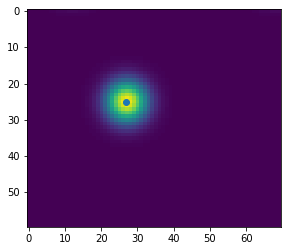

In [51]:
#This is to make the Gaussian fitting to patches easier. You will need this for the below TODO.

def fit_Gaussian_to_img(img,sig_x_est,sig_y_est):
    """This function returns the parameters of a 2D Gaussian fit
    input
    -----------
    img        -  Your 2-D input image.
    sig_x_est  - The estimated sigma in x.
    sig_y_est -  The estimated sigma in y.
    
    outputs
    -----------
    fitted parameters, x, y, sigma_x, sigma_y, amplitude
    
    """
    xrange = np.arange(0,img.shape[1])
    yrange =  np.arange(0,img.shape[0])
    xx,yy = np.meshgrid(xrange,yrange)
    param = Parameters()
    param.add('x_mu', value=img.shape[1]//2, min=0, max=img.shape[1], vary=True); 
    param.add('y_mu', value=img.shape[0]//2, min=0, max=img.shape[0], vary=True); 
    param.add('sig_x', value=sig_x_est, min=0, max=20, vary=True); 
    param.add('sig_y', value=sig_y_est, min=0, max=20, vary=True); 
    param.add('A', value=np.max(img), min=0, max=2*np.max(img), vary=True);
    
    res = minimize(gauss_residuals, param, args=(xx.reshape(-1),yy.reshape(-1),img.reshape(-1)))
    
    return res.params['x_mu'].value,res.params['y_mu'].value,res.params['sig_x'].value,res.params['sig_y'].value,res.params['A'].value

patch = g_img[40:100,80:150]
plt.imshow(patch)
a = fit_Gaussian_to_img(patch,10.,10.)
print(a)
plt.plot(a[0],a[1],'o')

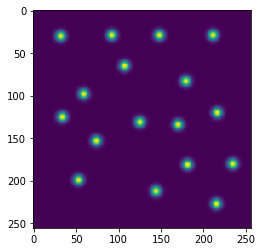

In [15]:
#Here I have simulated a number of Gaussians.
g_img = io.imread('images/2D_Gaus_sig4.png')
plt.imshow(g_img)
#Optional TODO: Using your code from the segmentation practical, find the Gaussians and estimate their parameters by fitting.
#Hint: You will need to find the maxima locations. This can be done through segmentation or through find maxima.
#Hint: With segmentation you can use the regionprops to return the centroid locations.
#Hint: Once you have the approximate location of the Gaussians then you need to extract each region and fit the 2-D Gaussians to them. (Use the function above: fit_Gaussian_to_img).
#Print the parameters below your code "gauss",num,"x_coord:",x_coord,"y_coord"

#Simulate the original image to make sure you have found the parameters correctly. This will involve generating the Gaussians one-by-one and adding them to the same image.
#Plot the original image and your simulated image side-by-side.

In [ ]:
#Optional TODO: 
#Add Noise to the image and see how the technique reduces in accuracy. Don't worry about quantifying this, just observe it for yourself.
#Your might want to use function: np.random.poisson(0.3,size=f.shape).